[*********************100%***********************]  1 of 1 completed


Note technique (sur 5): 3.18 [0.1834130783138427, 1.0, 1.0, 0.0, 1.0]
RF best params: {'max_depth': 5, 'n_estimators': 50}
SARIMAX sélectionné: order=(0, 1, 3), seas=(0, 0, 1, 5), AIC=5565.0
LinReg classification metrics (Acc, Prec, Rec, F1): (0.5260663507109005, 0.5921052631578947, 0.39473684210526316, 0.47368421052631576)
RF classification metrics (Acc, Prec, Rec, F1): (0.46445497630331756, 0.5061728395061729, 0.35964912280701755, 0.4205128205128205)
SARIMAX classification metrics (Acc, Prec, Rec, F1): (0.4834123222748815, 1.0, 0.043859649122807015, 0.08403361344537816)

--- Performance Régression ---
LinReg: MSE=72.995, MAE=5.543, RMSE=8.544, R2=0.987
RF: MSE=2856.858, MAE=29.060, RMSE=53.450, R2=0.497
SARIMAX: MSE=9807.110, MAE=71.283, RMSE=99.031, R2=-0.726


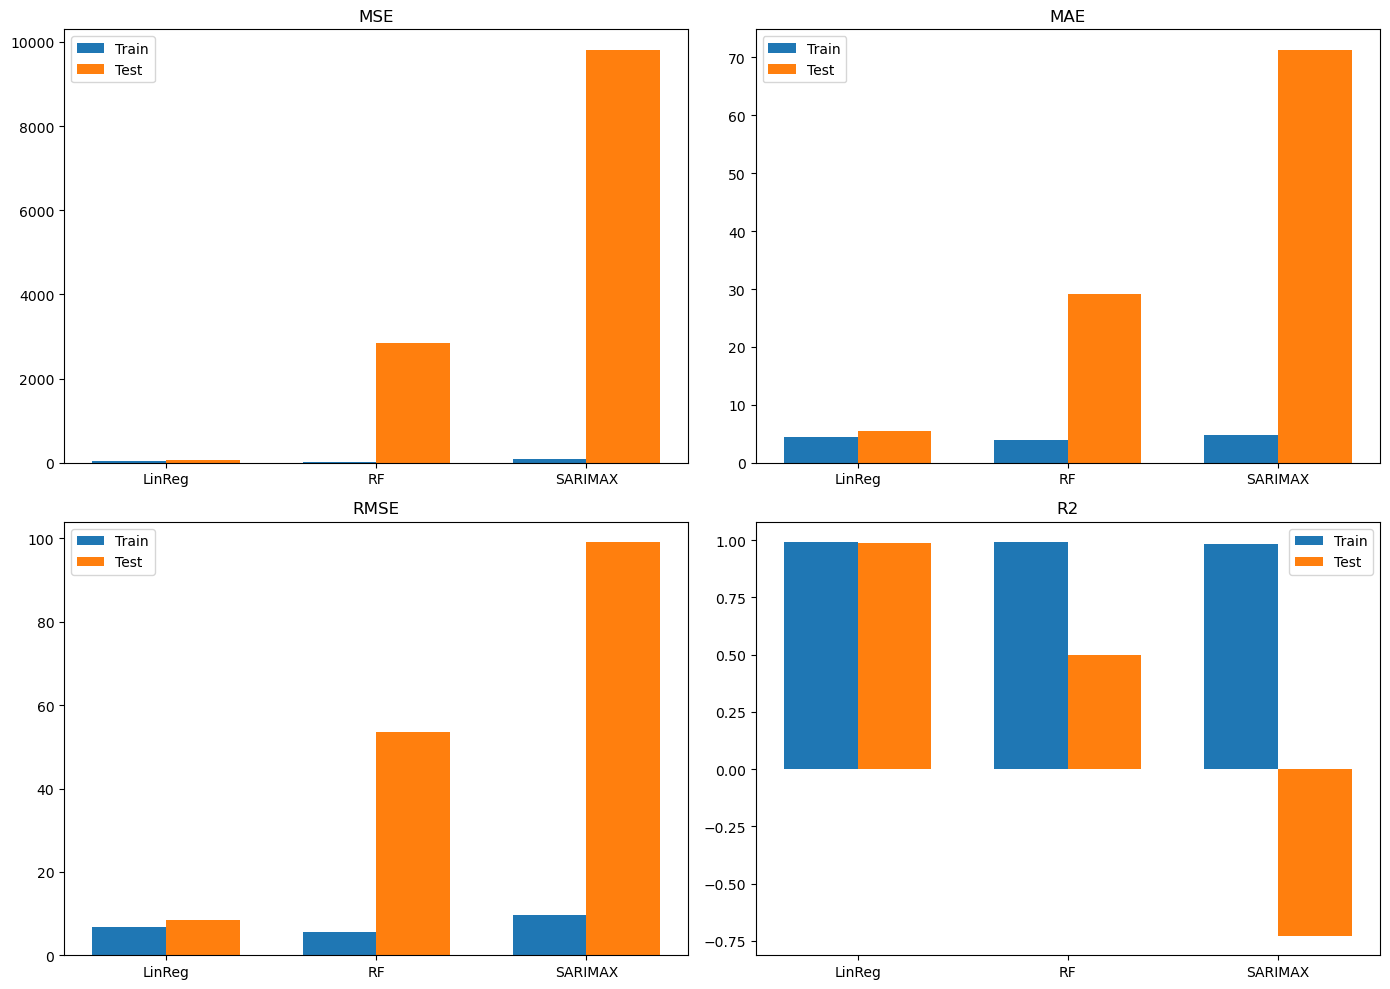


--- Performance Classification ---
LinReg: Acc=0.526, Prec=0.592, Rec=0.395, F1=0.474
RF: Acc=0.464, Prec=0.506, Rec=0.360, F1=0.421
SARIMAX: Acc=0.483, Prec=1.000, Rec=0.044, F1=0.084


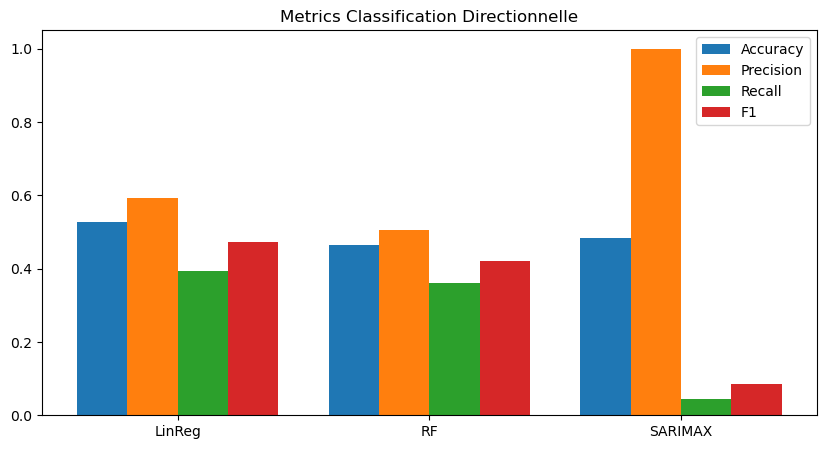


Meilleur modèle: LinReg


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import yfinance as yf 
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
import itertools
import statsmodels.api as sm
import pmdarima as pm

########################################
# Étape 1 : Calcul des indicateurs techniques
########################################

def compute_indicators(df):
    """
    Pour un dataframe possédant les colonnes : date, open, high, low, close, volume,
    on calcule ici 5 indicateurs : SMA, EMA, RSI, MACD, Bandes de Bollinger (%B) et le ROC.
    """
    df['sma20'] = df['close'].rolling(window=20).mean()
    df['ema12'] = df['close'].ewm(span=12, adjust=False).mean()

    delta = df['close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=14).mean()
    avg_loss = pd.Series(loss).rolling(window=14).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    df['rsi14'] = 100 - (100 / (1 + rs))

    df['ema26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = df['ema12'] - df['ema26']

    df['std20'] = df['close'].rolling(window=20).std()
    df['upperband'] = df['sma20'] + 2 * df['std20']
    df['lowerband'] = df['sma20'] - 2 * df['std20']
    df['percentb'] = (df['close'] - df['lowerband']) / (df['upperband'] - df['lowerband'] + 1e-10)

    df['roc'] = df['close'].pct_change(periods=14)
    return df

########################################
# Étape 2 : Scoring technique
########################################

def score_rsi(rsi):
    if rsi < 30: return 1.0
    elif rsi > 70: return 0.0
    else: return (70 - rsi) / 40

def score_macd(macd): return 1.0 if macd > 0 else 0.0

def score_sma(close, sma): return 1.0 if close > sma else 0.0

def score_bbands(percentb):
    if percentb < 0.2: return 1.0
    elif percentb > 0.8: return 0.0
    else: return 1 - ((percentb - 0.2) / 0.6)

def score_roc(roc): return 1.0 if roc > 0 else 0.0

def calculate_technical_score(latest_data):
    scores = [
        score_rsi(latest_data['rsi14']),
        score_macd(latest_data['macd']),
        score_sma(latest_data['close'], latest_data['sma20']),
        score_bbands(latest_data['percentb']),
        score_roc(latest_data['roc'])
    ]
    return sum(scores), scores

########################################
# Préparation des données
########################################

def prepare_features(df):
    df_feat = df.copy()
    df_feat['target'] = df_feat['close'].shift(-1)
    df_feat.dropna(inplace=True)
    features = ['open', 'high', 'low', 'close', 'volume', 'sma20', 'ema12', 'rsi14', 'macd', 'percentb', 'roc']
    return df_feat[features], df_feat['target']


def train_test_split_time_series(X, y, test_size=0.2):
    split = int(len(X) * (1 - test_size))
    return X.iloc[:split], X.iloc[split:], y.iloc[:split], y.iloc[split:]

########################################
# Modèles
########################################

def model_linear_regression(X_train, y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model, model.predict(X_train), model.predict(X_test)


def model_random_forest(X_train, y_train, X_test):
    rf = RandomForestRegressor(random_state=42)
    grid = {'n_estimators':[50,100],'max_depth':[3,5,7]}
    tscv = TimeSeriesSplit(n_splits=5)
    gs = GridSearchCV(rf, grid, cv=tscv, scoring='neg_mean_squared_error')
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    return best, best.predict(X_train), best.predict(X_test), gs.best_params_


def determine_d(y, sig=0.05, max_d=2):
    d, series = 0, y.copy()
    p_val = adfuller(series)[1]
    while p_val > sig and d < max_d:
        d += 1
        series = series.diff().dropna()
        p_val = adfuller(series)[1]
    return d


def model_sarimax_exog_grid(y_train, y_test, exog_train, exog_test, max_p=3, max_q=3, seas_period=5):
    d = determine_d(y_train)
    D = 0
    best_aic, best_mod, best_order, best_seas = np.inf, None, None, None
    for order in itertools.product(range(max_p+1), [d], range(max_q+1)):
        for seas in itertools.product([0,1],[D],[0,1],[seas_period]):
            try:
                mod = sm.tsa.statespace.SARIMAX(
                    endog=y_train,
                    exog=exog_train,
                    order=order,
                    seasonal_order=seas,
                    trend='t',
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)
                if mod.aic < best_aic:
                    best_aic = mod.aic
                    best_mod = mod
                    best_order = order
                    best_seas = seas
            except ValueError:
                continue
    print(f"SARIMAX sélectionné: order={best_order}, seas={best_seas}, AIC={best_aic:.1f}")
    return best_mod, best_mod.fittedvalues, best_mod.forecast(steps=len(y_test), exog=exog_test), best_order, best_seas

########################################
# Metrics & Plots
########################################

def compute_reg_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2


def compute_class_metrics(y_true, y_pred, close_series):
    """
    Calcule accuracy, precision, recall et F1 en comparant la direction des prix.
    """
    close_vals = close_series.values
    actual = (y_true.values > close_vals).astype(int)
    pred   = (y_pred > close_vals).astype(int)
    acc  = accuracy_score(actual, pred)
    prec = precision_score(actual, pred, zero_division=0)
    rec  = recall_score(actual, pred, zero_division=0)
    f1   = f1_score(actual, pred, zero_division=0)
    return acc, prec, rec, f1


def plot_regression_metrics(reg_metrics_train, reg_metrics_test):
    labels = list(reg_metrics_train.keys())
    metrics = ['MSE','MAE','RMSE','R2']
    fig, axes = plt.subplots(2,2, figsize=(14,10))
    axes = axes.flatten()
    for i, metric in enumerate(metrics):
        train_vals = [reg_metrics_train[m][i] for m in labels]
        test_vals  = [reg_metrics_test[m][i]  for m in labels]
        x = np.arange(len(labels))
        width = 0.35
        axes[i].bar(x-width/2, train_vals, width, label='Train')
        axes[i].bar(x+width/2, test_vals, width, label='Test')
        axes[i].set_xticks(x); axes[i].set_xticklabels(labels)
        axes[i].set_title(metric)
        axes[i].legend()
    plt.tight_layout(); plt.show()


def plot_classification_metrics(class_metrics):
    labels = list(class_metrics.keys())
    metrics = ['Accuracy','Precision','Recall','F1']
    vals = np.array([class_metrics[m] for m in labels])
    x = np.arange(len(labels))
    width = 0.2
    plt.figure(figsize=(10,5))
    for i in range(vals.shape[1]):
        plt.bar(x + (i-1.5)*width, vals[:,i], width, label=metrics[i])
    plt.xticks(x, labels)
    plt.title('Metrics Classification Directionnelle')
    plt.legend(); plt.show()

########################################
# Programme principal
########################################
def main():
    df = yf.download("META", start="2020-01-01", end="2024-04-09")
    df.reset_index(inplace=True)
    df.columns = [col[0].lower() if isinstance(col, tuple) else col.lower() for col in df.columns]
    df.sort_values('date', inplace=True); df.reset_index(drop=True, inplace=True)

    df = compute_indicators(df)
    tech_score, tech_scores = calculate_technical_score(df.iloc[-1])
    print("Note technique (sur 5):", round(tech_score,2), tech_scores)

    X, y = prepare_features(df)
    X_train, X_test, y_train, y_test = train_test_split_time_series(X, y)
    exog_train = np.log1p(X_train[['volume']]); exog_test = np.log1p(X_test[['volume']])

    reg_train, reg_test = {}, {}
    class_metrics = {}
    forecasts = {}

    lin, y_tr_lin, y_te_lin = model_linear_regression(X_train, y_train, X_test)
    reg_train['LinReg'] = compute_reg_metrics(y_train, y_tr_lin)
    reg_test['LinReg']  = compute_reg_metrics(y_test,  y_te_lin)
    forecasts['LinReg'] = (y_test, y_te_lin)

    rf, y_tr_rf, y_te_rf, best_rf = model_random_forest(X_train, y_train, X_test)
    print("RF best params:", best_rf)
    reg_train['RF'] = compute_reg_metrics(y_train, y_tr_rf)
    reg_test['RF']  = compute_reg_metrics(y_test,  y_te_rf)
    forecasts['RF'] = (y_test, y_te_rf)

    sar, y_tr_sar, y_te_sar, order_sar, seas_sar = model_sarimax_exog_grid(
        y_train, y_test, exog_train, exog_test)
    reg_train['SARIMAX'] = compute_reg_metrics(y_train, y_tr_sar)
    reg_test['SARIMAX']  = compute_reg_metrics(y_test,  y_te_sar)
    forecasts['SARIMAX'] = (y_test, y_te_sar)

    for name, (y_t, y_p) in forecasts.items():
        class_metrics[name] = compute_class_metrics(y_t, y_p, X_test['close'])
        print(f"{name} classification metrics (Acc, Prec, Rec, F1):", class_metrics[name])

    print("\n--- Performance Régression ---")
    for m in reg_test:
        print(f"{m}: MSE={reg_test[m][0]:.3f}, MAE={reg_test[m][1]:.3f}, RMSE={reg_test[m][2]:.3f}, R2={reg_test[m][3]:.3f}")
    plot_regression_metrics(reg_train, reg_test)

    print("\n--- Performance Classification ---")
    for m in class_metrics:
        print(f"{m}: Acc={class_metrics[m][0]:.3f}, Prec={class_metrics[m][1]:.3f}, Rec={class_metrics[m][2]:.3f}, F1={class_metrics[m][3]:.3f}")
    plot_classification_metrics(class_metrics)

    best = min(reg_test, key=lambda k: reg_test[k][0])
    print(f"\nMeilleur modèle: {best}")

if __name__ == '__main__':
    main()